# Analog Frontend aka Filterbank

In this notebook we will show how to use the analog frontend model.
To that end, we will make use of a very simple example - we will generate a one dimensional chirp signal of increasing frequency and process that with the AFE.


In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Import numpy
import numpy as np

# - Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 300

# - Rich printing
try:
    from rich import print
except:
    pass

## Parameter definition and initialization 
First, let's define all parameters for the AFE and initialize it.
Some parameters are needed to be set for initialization as they are commonly used, but there are many more hidden parameters which must be set after initialization if needed. 
We will see what the parameters mean in the process of this notebook.

In [2]:
# - import AFE
from rockpool.nn.modules.native.analogFrontEnd import AFE 

'Brian2' backend not found. Modules that rely on Brian will not be available.
'Brian2'backend not found. Modules that rely on Brian will not be available.
'Brian2' backend not found. Modules that rely on Brian will not be available.


In [3]:
# - AFE parameters

num_filters = 16         # number of filters (on the hardware that is fixed to 16)
Q = 5                    # Q (Quality) factor for the filters
fc1 = 100.               # center frequency of the first filter
f_factor = 1.325         # scaling to determin the center frequencies of the other filters

fs = 16000               # sampling frequency for the input data
LNA_gain = 0.0           # gain of the Low-Noise amplifier

thr_up = 0.8             # threshold of the neurons for spike conversion
leakage = 5.0            # leakage of the neurons for spike conversion
digital_counter = 8      # digital counter for the spike conversion

manual_scaling = None    # if None, the input is scaled by the LNA automatically
add_noise = True         # add simulated noise on each stage of the filtering
seed = None              # the AFE is subject to random mismatch, the mismatch can be seeded

# - initialize 

afe = AFE(Q=Q,
          fc1=fc1,
          f_factor=f_factor,
          thr_up=thr_up,
          leakage=leakage,
          LNA_gain=LNA_gain,
          fs=fs,
          digital_counter=digital_counter,
          num_filters=num_filters,
          manual_scaling=manual_scaling,
          add_noise=add_noise,
          seed=seed,
          )

## Input generation

For demonstation purposes we generate an artificial chirp signal of increasing frequency between 1 and 8000 Hz.
This chirp shall be processed by the AFE.

In [4]:
from rockpool.timeseries import TSContinuous

# create chrip
T = 1
f0 = 1
f1 = 7800.
dt = 1/fs
c = (f0 + f1) / T
p0 = 0
time = np.arange(0, T, dt)
inp = np.sin(p0 + 2 * np.pi * ((c / 2) * time ** 2 + f0 * time))

inp_ts = TSContinuous.from_clocked(inp, dt=dt, t_start=0)

The signal has a duration of 1 second and the frequencies in this chirp range from 1 to 8000 Hz which makes it hard to plot the raw signal. But let's visualize the beginning of the signal.

Then we can do a short time fourier transformation (STFT) to see the change in frequencies in the signal.

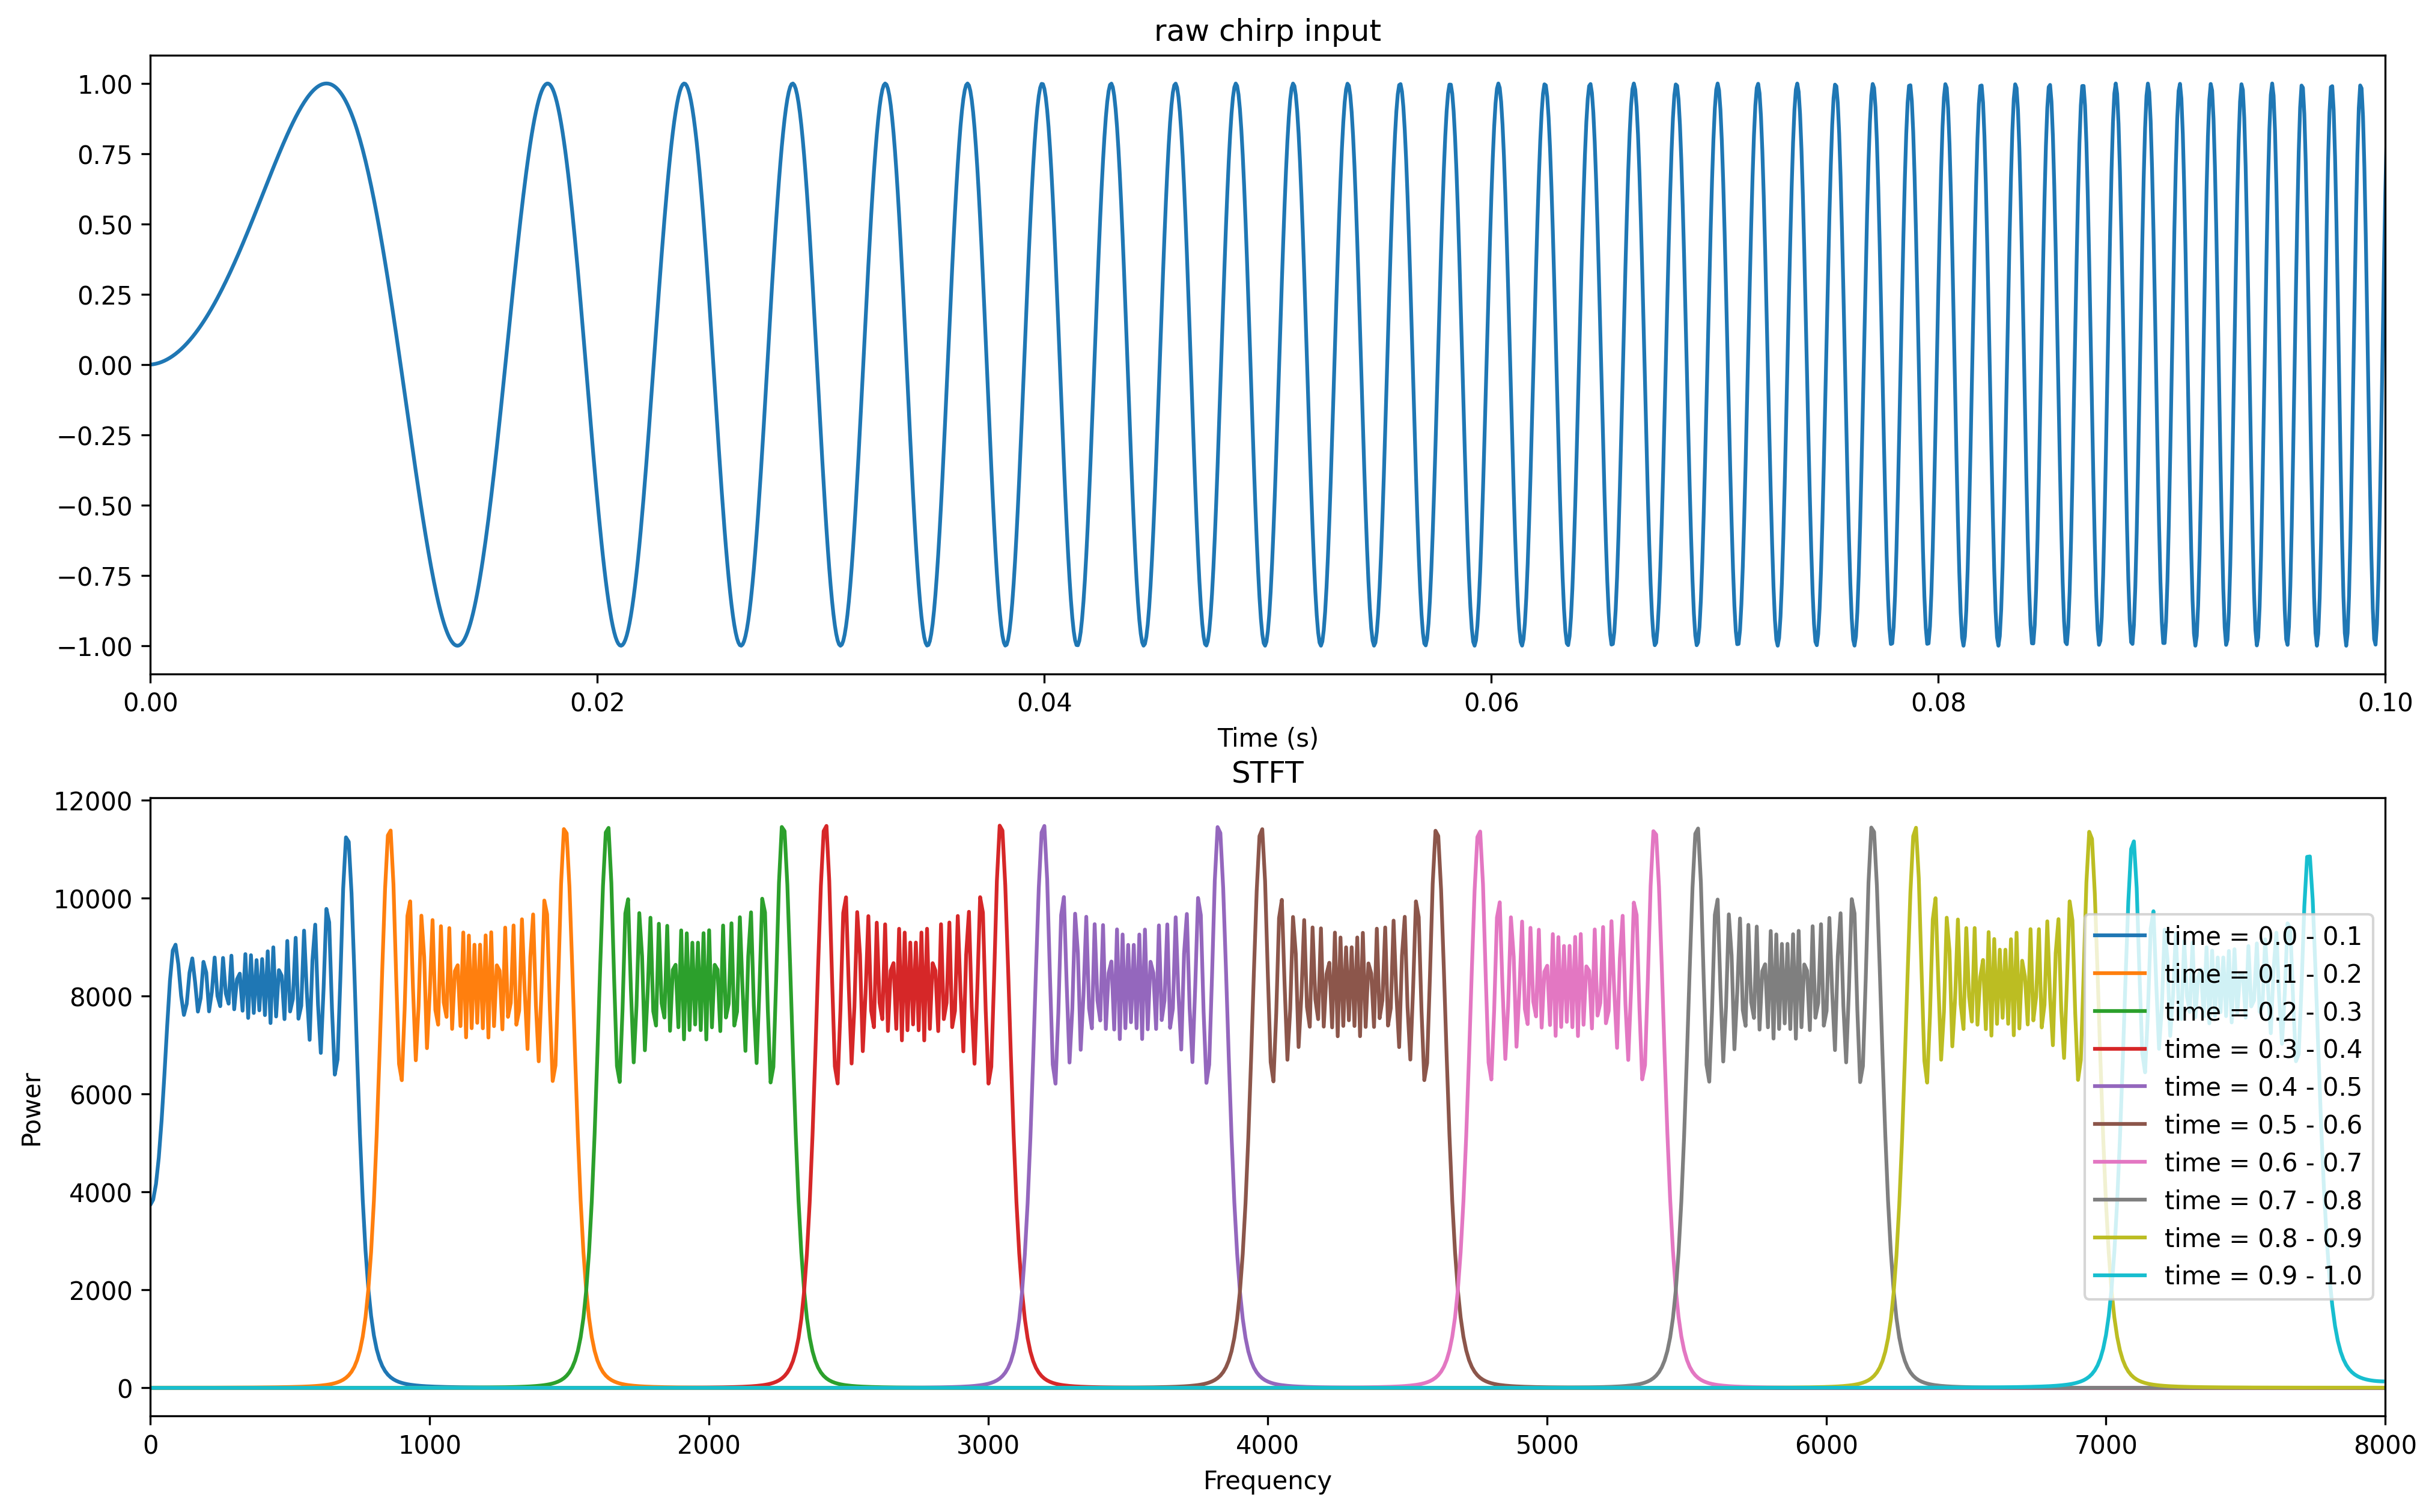

In [5]:
fig = plt.figure()
ax = fig.add_subplot(211)
inp_ts.plot()
ax.set_title("raw chirp input")
ax.set_xlim([0, 0.1])
ax.set_xlabel('Time (s)')
ax = fig.add_subplot(212)


for t in range(10):
    t_start = int(t * len(inp) / 10)
    t_stop = int((t + 1) * len(inp) / 10)
    data=inp[t_start:t_stop].T
    ps = np.abs(np.fft.fft(data))**2
    
    freqs = np.fft.fftfreq(data.size, dt)
    idx = np.argsort(freqs)
    
    ax.plot(freqs[idx], ps[idx], label="time = " + str(t_start/fs) + " - " + str(t_stop/fs))

ax.legend()
ax.set_xlim([0, 8000])
ax.set_ylabel("Power")
ax.set_xlabel("Frequency")
ax.set_title("STFT");



In the first panel we see the expected increase in frequency in the raw data. In the second panel we see that for increasing time slices the dominant frequencies components are increasing to 8kHz.

Now let's see how the AFE processes this data and plot the different stages.
The stages contain:
- Low-noise amplification
- Band-pass filters
- Full-wave rectification
- Spike conversion


In [6]:
filt_spikes, state, rec = afe.evolve(inp_ts, record=True)

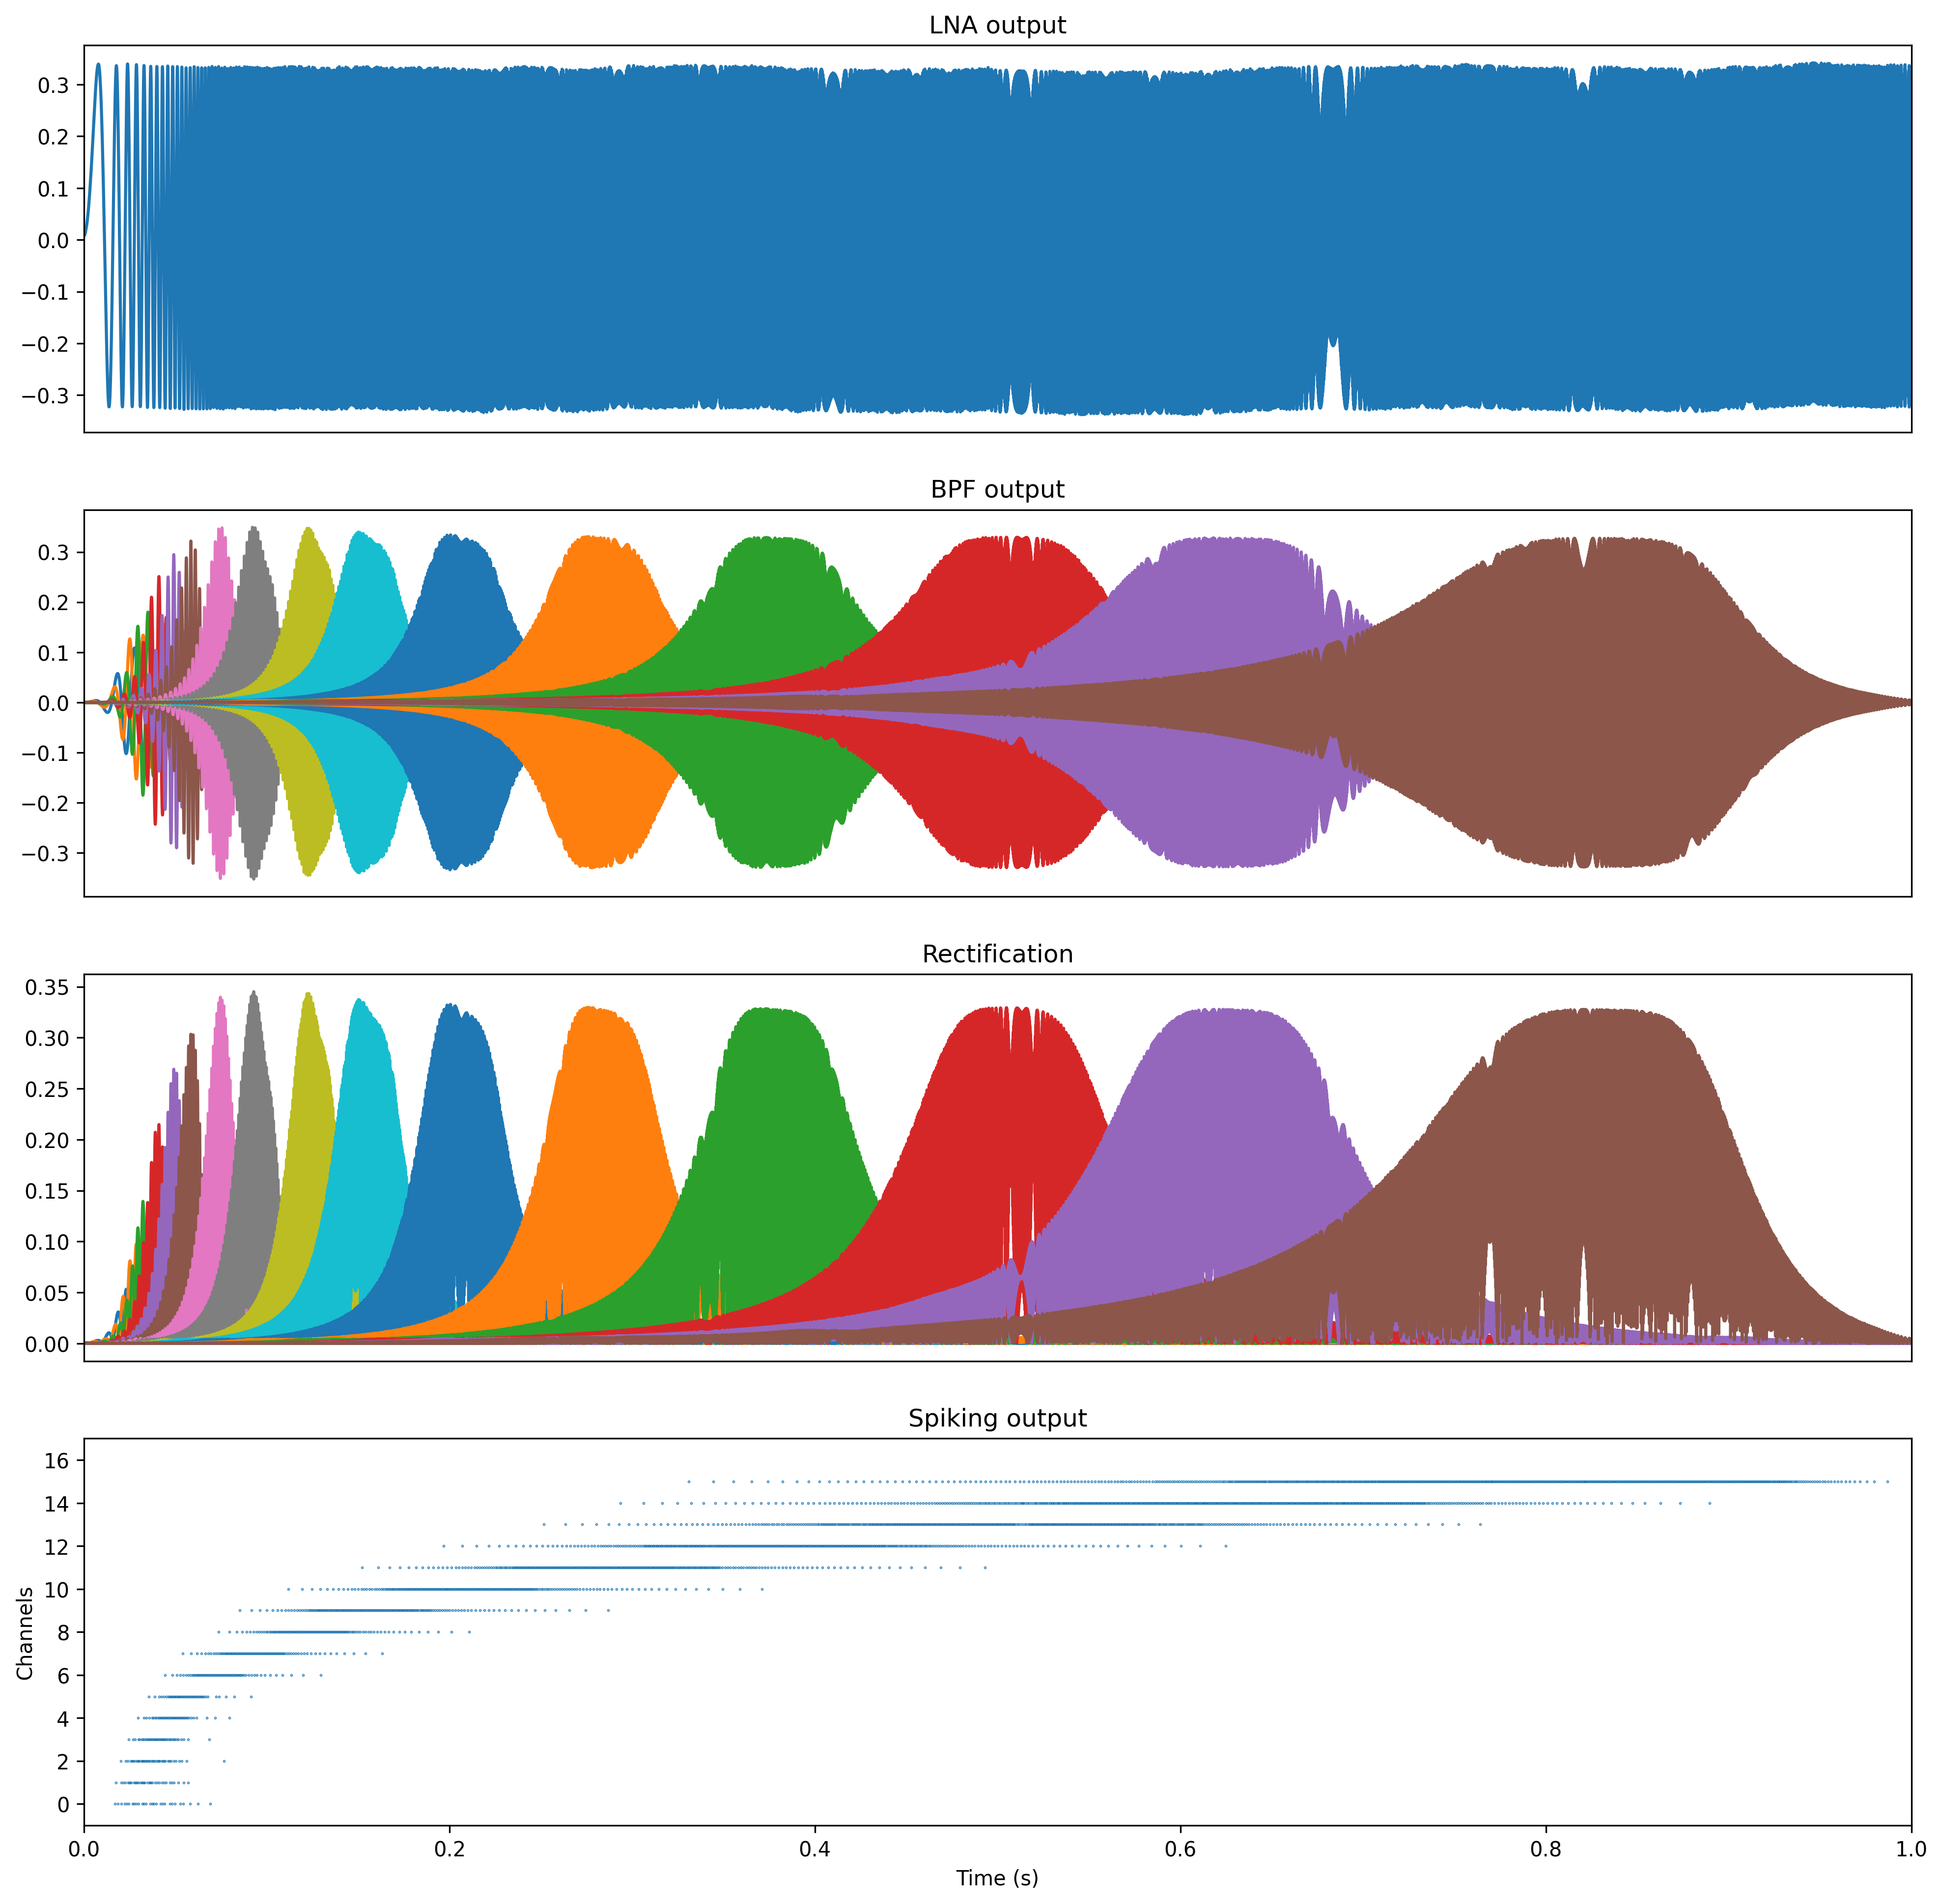

In [7]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(411)
plt.plot(rec['LNA_out'])
ax.set_xlim([0, fs])
ax.set_title("LNA output")
ax.set_xticks([])
ax = fig.add_subplot(412)
plt.plot(np.array(rec['BPF']).T)
ax.set_title("BPF output")
ax.set_xlim([0, fs])

ax.set_xticks([])

ax = fig.add_subplot(413)
plt.plot(np.array(rec['rect']).T)
ax.set_title("Rectification")
ax.set_xlim([0, fs])

ax.set_xticks([])

ax = fig.add_subplot(414)
filt_spikes.plot(s=0.1)
ax.set_title("Spiking output")

ax.set_xlabel('Time (s)');

In this previous plot we can see many things. Let's go through it piece by piece.

### LNA
The LNA rescales the input as can be seen on the y-axis. The original chirp was scales between -1 and 1, the output of the LNA is aroung +-0.3. This automatic rescaling can be changed with the parameter `manual_scaling` which allows the rescaling with arbitrary values.

### BPF

The bandpass filter get active in the sequence of their center frequency. You can also see that their center frequency is logarithmically distributed. The center frequency is calculated using this equation: 

$fc_i = fc_{i-1} f_\mathrm{factor}^i + fc_\mathrm{mismatch}$ 

Also, the width of the filter is scaled with its center frequency. This can be manipulated using the `Q` factor.

### Rectification

The rectification corresponds to an `abs` operation but is also subject to noise. 

### Spike conversion

As can be seen in the last panel, the different channels emit spikes corresponding to the center frequencies of their band-pass filters.

The spike conversion is done by charging a capacitor with a current corresponding to the output of the full-wave recifier. If the capacitor reaches a threshold, a spike is produced. As the capacitor is rather small on the hardware, the spike rate can get very high. The solution was to use a digital counter. The digital counter allows only every `n`th spike to pass and drops the rest. `n` can be set using the `digital_counter` parameter

The capacitor is subject to leak, which can be set with the `leakage` parameter. It can be used to lower the impact of the noise floor. If the leak is high, small background noise does not lead to threshold crossing. Try it, if the leak is reduced, the noise generated by the AFE get's visible in the spiking output.